# Master model development

## John Brandt

### Last updated: November 16 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

# Experiment log
*  Master version - 0.620 F1 after 70 epochs
    * Stacked 1x1 intro conv + conv - selu, no BN - 0.616 after 20 epochs
    * Remove 2 Conv Selus, GRU - FPA - Conv - Sigmoid, 60k params, 0.6
    * New indices are calculated correctly
    * Simpler FPA is more efficient with more stable learning
    * Lovasz works best per-image (0.61 vs. 0.56)
    * Boundary loss overfits with non-smoothed data
    * 14x14 input is a bad idea, because the border pixel makes sense for the final 3x3 conv
    * Temporal attention and CSSE work together
    * Min max scaling does not work
    * [-1, 1] scaling is better than [0, 1] scaling
    * DEM messes everything up because of banding every 10-15 meters, removing the slope improves test accuracy, but median filter with size of 5 may fix this issue
    * Smoothing the time dimension seems to help
    
* Reduced parameter size to 10, 24, 24 -- 0.61

* Smooth time dimension for all variable bands --

* Stack FPA module rather than FPA - Conv SELU

* FPA GRU - 1x1 GRU, 3x3 GRU, 5x5 Dilated GRU, combine hidden states within GRU

* Test adding versus multiplying for the concatenation of scales

In [1]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [4]:
ZONE_OUT_PROB = 0.20
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

gru_flt = 20
fpa_flt = 24
out_conv_flt = 20


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
existing = [int(x[:-4]) for x in os.listdir('../data/training-data-nov-22/') if ".DS" not in x]
N_SAMPLES = len(existing)

LABEL_SIZE = 14

    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

590 148


# Additional layer definitions

Some of these may be able to be removed, or moved to a src/*.py

*  Conv SELU
*  Conv BN ELU
*  Feature pyramid attention (with downsample / upsample)
*  Feature pyramid attention (w/o downsample / upsample)
*  Temporal attention
*  CSE, SSE, cCSE
*  Reflection padding


In [5]:
def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16, pad = True, padding = 'valid', dilated = False):
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = selu, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv
    
def fpa(inp, is_training, filter_count):
    one = conv_bn_elu(inp, is_training, 1, 'forward1', filter_count, False, 'valid')
    five = conv_bn_elu(inp, is_training, 5, 'down1', filter_count, False, 'valid')
    five_f = conv_bn_elu(five, is_training, 5, 'down1_f', filter_count, False, 'valid')
    three = conv_bn_elu(five, is_training, 3, 'down2', filter_count, False, 'valid')
    three_f = conv_bn_elu(three, is_training, 3, 'down2_f', filter_count, False, 'valid')
    
    three_up = get_deconv2d(three_f, filter_count, filter_count, "fpa1", is_training)
    five_up = get_deconv2d(five_f, filter_count, filter_count, "fpa2", is_training)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
                          is_training, 1, 'top1', filter_count, pad = False)
    four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    print("Sixteen top: {}".format(four_top.shape))
    
    
    concat_1 = tf.multiply(one, tf.add(three_up, five_up))
    concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_2.shape))
    return concat_2

def fpa(inp, is_training, filter_count, scope = 'fpa', topblock = False):
    one = conv_bn_elu(inp, is_training, 1, scope + 'forward1', filter_count, False, 'valid')
    three = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid') 
    five = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid', dilated = True) 
    concat_1 = tf.multiply(one, tf.add(three, five))
    
    if topblock:
        pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
        one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
                              is_training, 1, 'top1', filter_count, pad = False)
        four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
        print("Sixteen top: {}".format(four_top.shape))

        concat_1 = tf.add(concat_1, four_top)
    
    return concat_1

    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init


def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        kernel_initializer = bilinear_init)(inp)
    x = ELU()(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied

In [6]:
def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps


# Model definition

## Placeholders

In [7]:
n_bands = 17
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling

## Layers

In [8]:
# Unsure if this block is better replaced by 1x1 ConvGRU output
#stacked = tf.reshape(inp, (-1, 16, 16, n_bands*24))
#pixel_information = Conv2D(filters = gru_flt, kernel_size = (1, 1),
#            padding = 'valid', activation = selu, kernel_initializer = lecun_normal())(stacked)
    
# 3 x 3 GRU

inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)

# Skip connect, CSSE, 5x5 drop block
#steps = temporal_attention(steps, gru_flt*2)# - unsure if more useful after smoothing
#gru_out = gru_out + steps # identity concatenation for a skip connect
gru_out = tf.concat([gru_out, dem], axis = -1)
#gru_out = tf.concat([gru_out, pixel_information], axis = -1)
csse1 = csse_block(gru_out, 'csse1')
drop_block1 = DropBlock2D(keep_prob=keep_rate, block_size=5)
csse1 = drop_block1(csse1, is_training)

# Light FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt, topblock = True)
csse2 = csse_block(fpa1, 'csse2')
drop_block2 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse2 = drop_block2(csse2, is_training)


# Skip connect
x = tf.concat([csse2, csse1], axis = -1)

# Conv SELU, 3x3 drop
#x = fpa(x, is_training, fpa_flt)
#x = csse_block(x, 'csse3')
#x = conv_bn_elu(x, is_training, 3, "out_1", out_conv_flt, True, 'valid')
#drop_block4 = DropBlock2D(keep_prob=keep_rate, block_size=3)
#x = drop_block4(x, is_training)

#hypercolumn = tf.concat([csse1, csse2, x], axis = -1)

# Conv SELU, 16x16 - 14x14
x = conv_bn_elu(x, is_training, 3, "out_2", 32, False, 'valid')

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 16), zoneout: 0.2
(3, 3, 36, 40)
(1, 1, 40, 1)
(?, 16, 16, 40)
(3, 3, 36, 40)
(1, 1, 40, 1)
(?, 16, 16, 40)
Down block output shape (?, 16, 16, 40)
Sixteen top: (?, 16, 16, 24)
Initializing last sigmoid bias with -2.94 constant


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 100949 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [10]:
data_x = np.load("../data/processed/data_x_processed.npy")
data_y = np.load("../data/processed/data_y_processed.npy")
lengths = np.load("../data/processed/length_processed.npy")

In [11]:
from scipy.ndimage import median_filter
for sample in tnrange(0, len(data_x)):
    filtered = median_filter(data_x[sample, 0, :, :, 10], size = 5)
    data_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
#data_x = np.delete(data_x, 10, -1)
print(data_x.shape)


(738, 24, 16, 16, 17)


# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [12]:
below_1 = [i for i, val in enumerate(data_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x) if np.max(val) > 1.5]
outliers = below_1 + above_1
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

The outliers are: [225, 646, 318, 609], totalling 4


[-2.02274, -1.889741, -720.65295, -3.1381047] [1089.9442]


## Temporal Smoothing

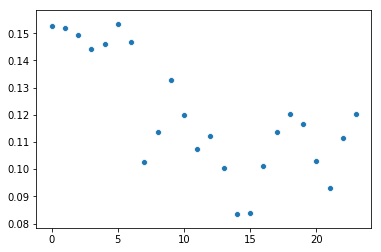

In [13]:
sns.scatterplot(y = data_x[255, :, 10, 14, 5], x = [x for x in range(24)])

In [14]:
min_all = []
max_all = []
for band in range(0, data_x.shape[-1]):

    mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The data has been scaled to [-1.0000001192092896, 1.0]


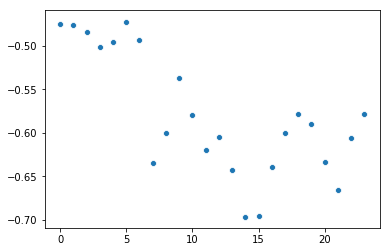

In [15]:
sns.scatterplot(y = data_x[255, :, 10, 14, 5], x = [x for x in range(24)])

# Split train, test

In [16]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")
df4 = pd.read_csv("../data/kenya-train.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df4 = df4.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)


lens = [len(x) for x in [df, df1, df2, df3, df4]]

df = pd.concat([df, df1, df2, df3, df4], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/training-data-nov-22/') if ".DS" not in x]
N_SAMPLES = len(existing)
df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)

plot_ids = sorted(df['PLOT_ID'].unique())
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x for x in outliers]))]
N_SAMPLES = len(data_x)

# Positive (tree) and negative (background) pixel metrics

In [17]:
#! In development

positive_x = []
negative_x = []

#for sample in data_y:
#    for row in range(0,14):
#        for column in range(0,14):
#            if data_y[sample, row, column] == 1:

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

In [18]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []

for i, val in enumerate([x for x in range(len(data_x))]):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [19]:
test_x = np.load("../data/processed/test_x_processed.npy")
test_y = np.load("../data/processed/test_y_processed.npy")
test_lengths = np.load("../data/processed/test_length_processed.npy")


below_1 = [i for i, val in enumerate(test_x) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(test_x) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(test_x) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x) if np.max(val) > 1.5]
outliers = below_1 + above_1
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]
print(np.min(test_x[19]))

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [109], totalling 1


[] [2.60685]
-1.0386096



The data has been scaled to [-1.0000001192092896, 1.0]
(126, 24, 16, 16, 17)


In [20]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
#print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
#print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 37.96031746031746
Test STD Y 58.708913467497766
Train mean NDVI
Test mean NDVI


In [21]:
np.min(test_x[19, :, :, :])

-0.97798425

# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [259]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, smooth = 0.025):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)


def bce_lv(y_true, y_pred, alpha, smooth = 0.075, mask = None, ):
    bce = (0.95 - alpha) * weighted_bce_loss(y_true, y_pred, 1.5, smooth = smooth)
    #surf = surface_loss(y_true, y_pred)
    lv = (0.05 + alpha) * lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    #global_loss = (1 - alpha) * (bce + lv)
    #regional_loss = alpha * surf
    return bce+lv


def lovasz(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return lv

#! Move to a src.py
def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x)) if x not in [11, 112, 3, 97, 57]]
    for test_sample in test_ids:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    for thresh in range(8, 13):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)

            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [23]:
[np.percentile(np.sum(data_y, axis = (1, 2)), x) for x in range(0, 100, 10)]

[0.0, 0.0, 0.0, 0.0, 6.0, 13.0, 22.0, 32.0, 46.0, 87.0]

# Equibatch creation

In [24]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

def equibatch(train_ids, lovasz = False):
    first_len = 5
    second_len = 9
    third_len = 14
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    zero_ids = [x for x, z in zip(ix, percs) if z == 0]
    one_ids = [x for x, z in zip(ix, percs) if 0 < z <= first_len]
    two_ids = [x for x, z in zip(ix, percs) if first_len < z <= second_len]
    three_ids = [x for x, z in zip(ix, percs) if second_len < z <= third_len]
    four_ids = [x for x, z in zip(ix, percs) if third_len < z <= 19]
    five_ids = [x for x, z in zip(ix, percs) if 19 < z < 27]
    six_ids = [x for x, z in zip(ix, percs) if 27 < z <= 33]
    seven_ids = [x for x, z in zip(ix, percs) if 33 < z <= 41]
    eight_ids = [x for x, z in zip(ix, percs) if 41 < z <= 56]
    nine_ids =  [x for x, z in zip(ix, percs) if 56 < z <= 80]
    ten_ids =  [x for x, z in zip(ix, percs) if 80 < z <= 120]
    eleven_ids = [x for x, z in zip(ix, percs) if 120 < z]
    #ten_ids = [x for x, z in zip(ix, percs) if 125 < z]

    new_batches = []
    maxes = [len(zero_ids), len(one_ids), len(two_ids), len(three_ids), len(four_ids),
             len(five_ids), len(six_ids), len(seven_ids), len(eight_ids), len(nine_ids), len(ten_ids), len(eleven_ids)]#, len(ten_ids)]
    cur_ids = [0] * 12
    iter_len = len(train_ids)//(len(maxes)+3) if not lovasz else len(train_ids)//8
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [zero_ids[cur_ids[0]], zero_ids[cur_ids[0] + 1], one_ids[cur_ids[1]], two_ids[cur_ids[2]],
                    three_ids[cur_ids[3]], four_ids[cur_ids[4]], five_ids[cur_ids[5]],
                    six_ids[cur_ids[6]], seven_ids[cur_ids[7]], eight_ids[cur_ids[8]],
                               nine_ids[cur_ids[9]], ten_ids[cur_ids[10]], eleven_ids[cur_ids[11]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

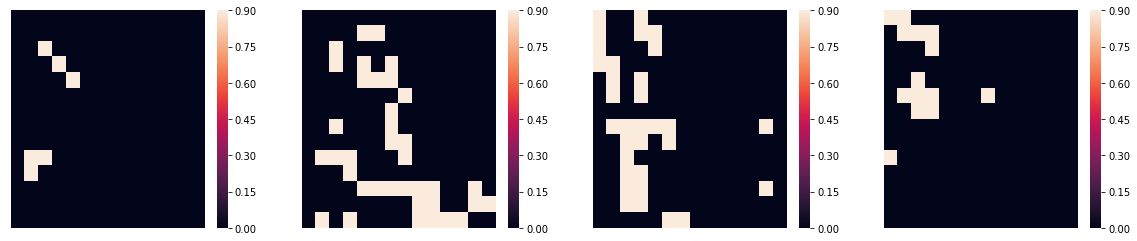

In [25]:
#! Todo: Move to one cell, rather than 3
batch = equibatch(train_ids, True)
multiplot([x.reshape((14, 14)) for x in train_y[batch[:4]]])

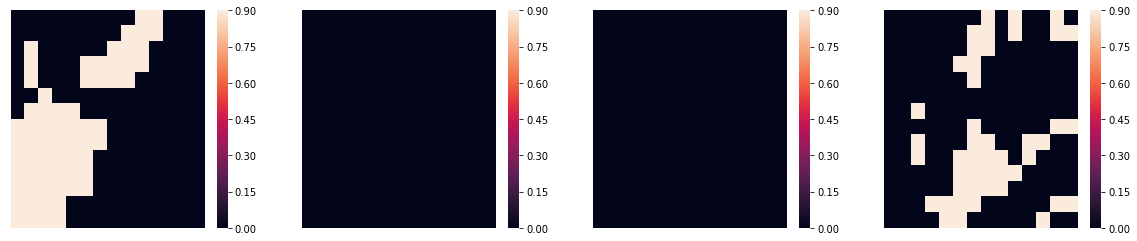

In [26]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

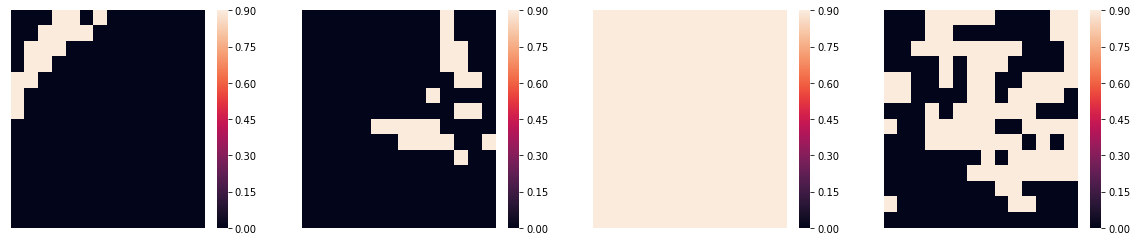

In [27]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

In [28]:
# This cell should be run to do fine-tuning, if commented - train from scratch

#new_saver = tf.train.import_meta_graph('../models/new_model/model.meta')
#new_saver.restore(sess, tf.train.latest_checkpoint('../models/new_model/'))

# Graph set up

In [29]:
FRESH_START = True
best_val = 0.73

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 4e-3
test_ids = [x for x in range(0, len(test_x))]


print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), N_SAMPLES))

    #optimizer = tf.train.AdamOptimizer(LEARNING_RATE, epsilon = 1e-8)
    optimizer = AdaBoundOptimizer(3e-3, 1e-1)
    train_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha)
    l2_loss = tf.losses.get_regularization_loss()
    train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(0.001)
    ft_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha)
    #wu_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.5)
    
    test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(ft_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)
    
print("The graph has been finalized")

Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 100949 parameters
Restarting training from scratch on 2936 train and 126 test samples, total 734
()
()
The graph has been finalized


# Model training

In [193]:
best_val = 0.73

train_ids = [x for x in range(len(train_y))]

for i in range(1, 200):
    al = np.min([i*0.005, 0.075])
    #randomize = train_ids
    #np.random.shuffle(randomize)
    randomize = equibatch(train_ids, lovasz = False)
    print("Loss: {} 1.5 weighted BCE + {} Image Lovasz".format( (0.95-al), (0.05 + al)))
    op = train_op
    loss = train_loss
    #op = ft_op
    #loss = ft_loss
    BATCH_SIZE = 16
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.002), 0.85)),
                                         alpha: al
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    f1 = calculate_metrics()
    if f1 > (best_val - 0.012):
        best_val = f1
        print("Saving model with {}".format(f1))
        save_path = saver.save(sess, "../models/nov-25/model")

Loss: 0.945 1.5 weighted BCE + 0.055 Image Lovasz


Epoch 1: Loss 0.5809999704360962
Val loss: 0.3540000021457672 Thresh: 0.5 F1: 0.73 Recall: 0.725 Precision: 0.736 Error: 0.016
Saving model with 0.7304152637485971
Loss: 0.94 1.5 weighted BCE + 0.060000000000000005 Image Lovasz


Epoch 2: Loss 0.5740000009536743
Val loss: 0.3889999985694885 Thresh: 0.6 F1: 0.737 Recall: 0.71 Precision: 0.767 Error: 0.08
Saving model with 0.7369222403480152
Loss: 0.9349999999999999 1.5 weighted BCE + 0.065 Image Lovasz


Epoch 3: Loss 0.5740000009536743
Val loss: 0.3330000042915344 Thresh: 0.6 F1: 0.749 Recall: 0.802 Precision: 0.703 Error: 0.123
Saving model with 0.7492767598842817
Loss: 0.9299999999999999 1.5 weighted BCE + 0.07 Image Lovasz


Epoch 4: Loss 0.5680000185966492
Val loss: 0.3840000033378601 Thresh: 0.6 F1: 0.737 Recall: 0.683 Precision: 0.801 Error: 0.172
Saving model with 0.7373463861695481
Loss: 0.9249999999999999 1.5 weighted BCE + 0.07500000000000001 Image Lovasz


Epoch 5: Loss 0.5669999718666077
Val loss: 0.32600000500679016 Thresh: 0.5 F1: 0.74 Recall: 0.739 Precision: 0.74 Error: 0.001
Saving model with 0.7395432964051548
Loss: 0.9199999999999999 1.5 weighted BCE + 0.08 Image Lovasz


Epoch 6: Loss 0.5690000057220459
Val loss: 0.4269999861717224 Thresh: 0.6 F1: 0.72 Recall: 0.648 Precision: 0.81 Error: 0.25
Loss: 0.9149999999999999 1.5 weighted BCE + 0.085 Image Lovasz


Epoch 7: Loss 0.5640000104904175
Val loss: 0.32899999618530273 Thresh: 0.5 F1: 0.752 Recall: 0.742 Precision: 0.762 Error: 0.027
Saving model with 0.7518696283067305
Loss: 0.9099999999999999 1.5 weighted BCE + 0.09 Image Lovasz


Epoch 8: Loss 0.5600000023841858
Val loss: 0.3930000066757202 Thresh: 0.6 F1: 0.725 Recall: 0.674 Precision: 0.785 Error: 0.164
Loss: 0.9049999999999999 1.5 weighted BCE + 0.095 Image Lovasz


Epoch 9: Loss 0.5580000281333923
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.736 Recall: 0.727 Precision: 0.745 Error: 0.026
Loss: 0.8999999999999999 1.5 weighted BCE + 0.1 Image Lovasz


Epoch 10: Loss 0.5600000023841858
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.747 Recall: 0.771 Precision: 0.724 Error: 0.06
Saving model with 0.7469963839962673
Loss: 0.8949999999999999 1.5 weighted BCE + 0.10500000000000001 Image Lovasz


Epoch 11: Loss 0.5580000281333923
Val loss: 0.38199999928474426 Thresh: 0.6 F1: 0.715 Recall: 0.669 Precision: 0.767 Error: 0.146
Loss: 0.8899999999999999 1.5 weighted BCE + 0.11 Image Lovasz


Epoch 12: Loss 0.5540000200271606
Val loss: 0.3889999985694885 Thresh: 0.6 F1: 0.71 Recall: 0.666 Precision: 0.76 Error: 0.141
Loss: 0.885 1.5 weighted BCE + 0.115 Image Lovasz


Epoch 13: Loss 0.5569999814033508
Val loss: 0.34200000762939453 Thresh: 0.6 F1: 0.742 Recall: 0.772 Precision: 0.714 Error: 0.075
Saving model with 0.7421250587682183
Loss: 0.8799999999999999 1.5 weighted BCE + 0.12000000000000001 Image Lovasz


Epoch 14: Loss 0.5519999861717224
Val loss: 0.40400001406669617 Thresh: 0.6 F1: 0.714 Recall: 0.635 Precision: 0.816 Error: 0.286
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 15: Loss 0.5519999861717224
Val loss: 0.3580000102519989 Thresh: 0.6 F1: 0.734 Recall: 0.722 Precision: 0.745 Error: 0.032
Saving model with 0.7335486026055005
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 16: Loss 0.5519999861717224
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.75 Recall: 0.746 Precision: 0.754 Error: 0.011
Saving model with 0.7501406232422094
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 17: Loss 0.5490000247955322
Val loss: 0.40400001406669617 Thresh: 0.6 F1: 0.712 Recall: 0.638 Precision: 0.806 Error: 0.264
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 18: Loss 0.550000011920929
Val loss: 0.39800000190734863 Thresh: 0.6 F1: 0.714 Recall: 0.639 Precision: 0.809 Error: 0.266
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 19: Loss 0.5490000247955322
Val loss: 0.38999998569488525 Thresh: 0.6 F1: 0.725 Recall: 0.693 Precision: 0.76 Error: 0.095
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 20: Loss 0.546999990940094
Val loss: 0.3880000114440918 Thresh: 0.6 F1: 0.724 Recall: 0.663 Precision: 0.798 Error: 0.204
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 21: Loss 0.546999990940094
Val loss: 0.3479999899864197 Thresh: 0.6 F1: 0.755 Recall: 0.759 Precision: 0.75 Error: 0.012
Saving model with 0.7546955036994878
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 22: Loss 0.5440000295639038
Val loss: 0.382999986410141 Thresh: 0.6 F1: 0.726 Recall: 0.682 Precision: 0.776 Error: 0.138
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 23: Loss 0.5429999828338623
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.734 Recall: 0.707 Precision: 0.763 Error: 0.079
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 24: Loss 0.5490000247955322
Val loss: 0.38499999046325684 Thresh: 0.6 F1: 0.723 Recall: 0.673 Precision: 0.782 Error: 0.162
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 25: Loss 0.5429999828338623
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.72 Recall: 0.72 Precision: 0.721 Error: 0.002
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 26: Loss 0.5410000085830688
Val loss: 0.3490000069141388 Thresh: 0.6 F1: 0.751 Recall: 0.748 Precision: 0.755 Error: 0.009
Saving model with 0.7514919491048305
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 27: Loss 0.5410000085830688
Val loss: 0.35600000619888306 Thresh: 0.6 F1: 0.736 Recall: 0.718 Precision: 0.753 Error: 0.049
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 28: Loss 0.5400000214576721
Val loss: 0.3619999885559082 Thresh: 0.55 F1: 0.726 Recall: 0.696 Precision: 0.759 Error: 0.091
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 29: Loss 0.5389999747276306
Val loss: 0.35499998927116394 Thresh: 0.6 F1: 0.742 Recall: 0.726 Precision: 0.76 Error: 0.046
Saving model with 0.7424527258653103
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 30: Loss 0.5410000085830688
Val loss: 0.44600000977516174 Thresh: 0.6 F1: 0.693 Recall: 0.596 Precision: 0.829 Error: 0.391
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 31: Loss 0.5379999876022339
Val loss: 0.47999998927116394 Thresh: 0.6 F1: 0.684 Recall: 0.573 Precision: 0.85 Error: 0.484
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 32: Loss 0.5389999747276306
Val loss: 0.36500000953674316 Thresh: 0.6 F1: 0.737 Recall: 0.709 Precision: 0.768 Error: 0.083
Saving model with 0.7374823503855763
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 33: Loss 0.5360000133514404
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.733 Recall: 0.703 Precision: 0.767 Error: 0.091
Saving model with 0.733448723496322
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 34: Loss 0.5370000004768372
Val loss: 0.39399999380111694 Thresh: 0.6 F1: 0.723 Recall: 0.679 Precision: 0.774 Error: 0.139
Saving model with 0.7234267583289266
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 35: Loss 0.5370000004768372
Val loss: 0.34200000762939453 Thresh: 0.6 F1: 0.741 Recall: 0.753 Precision: 0.73 Error: 0.031
Saving model with 0.7412683823529411
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 36: Loss 0.5360000133514404
Val loss: 0.3499999940395355 Thresh: 0.5 F1: 0.737 Recall: 0.701 Precision: 0.778 Error: 0.109
Saving model with 0.7373954087105772
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 37: Loss 0.5350000262260437
Val loss: 0.3569999933242798 Thresh: 0.5 F1: 0.718 Recall: 0.674 Precision: 0.769 Error: 0.141
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 38: Loss 0.5360000133514404
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.721 Recall: 0.703 Precision: 0.738 Error: 0.05
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 39: Loss 0.5339999794960022
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.727 Recall: 0.71 Precision: 0.744 Error: 0.049
Saving model with 0.7265098818593354
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 40: Loss 0.5329999923706055
Val loss: 0.39100000262260437 Thresh: 0.6 F1: 0.719 Recall: 0.667 Precision: 0.779 Error: 0.169
Saving model with 0.7185478823283955
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 41: Loss 0.5350000262260437
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.732 Recall: 0.683 Precision: 0.788 Error: 0.155
Saving model with 0.731758530183727
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 42: Loss 0.5320000052452087
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.72 Recall: 0.677 Precision: 0.768 Error: 0.134
Saving model with 0.7198897370653096
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 43: Loss 0.5320000052452087
Val loss: 0.367000013589859 Thresh: 0.55 F1: 0.716 Recall: 0.669 Precision: 0.771 Error: 0.152
Saving model with 0.716433603196299
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 44: Loss 0.5320000052452087
Val loss: 0.375 Thresh: 0.6 F1: 0.73 Recall: 0.699 Precision: 0.765 Error: 0.095
Saving model with 0.7302375809935205
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 45: Loss 0.5329999923706055
Val loss: 0.3869999945163727 Thresh: 0.6 F1: 0.719 Recall: 0.683 Precision: 0.759 Error: 0.111
Saving model with 0.7191854233654877
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 46: Loss 0.5329999923706055
Val loss: 0.4359999895095825 Thresh: 0.6 F1: 0.657 Recall: 0.575 Precision: 0.767 Error: 0.335
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 47: Loss 0.5320000052452087
Val loss: 0.3919999897480011 Thresh: 0.55 F1: 0.707 Recall: 0.653 Precision: 0.771 Error: 0.18
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 48: Loss 0.531000018119812
Val loss: 0.3869999945163727 Thresh: 0.6 F1: 0.73 Recall: 0.692 Precision: 0.772 Error: 0.116
Saving model with 0.7295476419634265
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 49: Loss 0.531000018119812
Val loss: 0.37700000405311584 Thresh: 0.55 F1: 0.714 Recall: 0.668 Precision: 0.766 Error: 0.146
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 50: Loss 0.531000018119812
Val loss: 0.4490000009536743 Thresh: 0.6 F1: 0.687 Recall: 0.594 Precision: 0.815 Error: 0.372
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 51: Loss 0.5299999713897705
Val loss: 0.3889999985694885 Thresh: 0.5 F1: 0.702 Recall: 0.628 Precision: 0.795 Error: 0.267
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 52: Loss 0.5289999842643738
Val loss: 0.3700000047683716 Thresh: 0.55 F1: 0.716 Recall: 0.675 Precision: 0.763 Error: 0.131
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 53: Loss 0.5289999842643738
Val loss: 0.38999998569488525 Thresh: 0.6 F1: 0.708 Recall: 0.666 Precision: 0.755 Error: 0.135
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 54: Loss 0.527999997138977
Val loss: 0.38999998569488525 Thresh: 0.6 F1: 0.72 Recall: 0.669 Precision: 0.779 Error: 0.166
Saving model with 0.719732581218009
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 55: Loss 0.5289999842643738
Val loss: 0.38100001215934753 Thresh: 0.55 F1: 0.716 Recall: 0.655 Precision: 0.788 Error: 0.202
Saving model with 0.7155039556149183
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 56: Loss 0.5339999794960022
Val loss: 0.3790000081062317 Thresh: 0.5 F1: 0.708 Recall: 0.652 Precision: 0.774 Error: 0.188
Saving model with 0.707622298065984
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 57: Loss 0.5299999713897705
Val loss: 0.40799999237060547 Thresh: 0.6 F1: 0.7 Recall: 0.641 Precision: 0.771 Error: 0.203
Saving model with 0.6995994659546061
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 58: Loss 0.527999997138977
Val loss: 0.34299999475479126 Thresh: 0.55 F1: 0.732 Recall: 0.721 Precision: 0.744 Error: 0.032
Saving model with 0.7324351408529117
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 59: Loss 0.527999997138977
Val loss: 0.3869999945163727 Thresh: 0.6 F1: 0.728 Recall: 0.681 Precision: 0.781 Error: 0.146
Saving model with 0.7279435016338147
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 60: Loss 0.527999997138977
Val loss: 0.3799999952316284 Thresh: 0.45 F1: 0.709 Recall: 0.624 Precision: 0.82 Error: 0.315
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 61: Loss 0.5260000228881836
Val loss: 0.37700000405311584 Thresh: 0.55 F1: 0.711 Recall: 0.655 Precision: 0.779 Error: 0.19
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 62: Loss 0.5270000100135803
Val loss: 0.3619999885559082 Thresh: 0.55 F1: 0.707 Recall: 0.69 Precision: 0.725 Error: 0.051
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 63: Loss 0.5249999761581421
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.722 Recall: 0.685 Precision: 0.763 Error: 0.114
Saving model with 0.7217465753424658
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 64: Loss 0.5260000228881836
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.711 Recall: 0.683 Precision: 0.742 Error: 0.086
Saving model with 0.7111255692908263
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 65: Loss 0.5260000228881836
Val loss: 0.3700000047683716 Thresh: 0.55 F1: 0.712 Recall: 0.68 Precision: 0.748 Error: 0.1
Saving model with 0.7119922422152786
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 66: Loss 0.5249999761581421
Val loss: 0.37299999594688416 Thresh: 0.55 F1: 0.707 Recall: 0.672 Precision: 0.746 Error: 0.111
Saving model with 0.7069667738478028
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 67: Loss 0.527999997138977
Val loss: 0.4009999930858612 Thresh: 0.6 F1: 0.702 Recall: 0.65 Precision: 0.763 Error: 0.175
Saving model with 0.7019660875897222
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 68: Loss 0.5260000228881836
Val loss: 0.4050000011920929 Thresh: 0.6 F1: 0.698 Recall: 0.631 Precision: 0.782 Error: 0.238
Saving model with 0.698473668250278
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 69: Loss 0.5249999761581421
Val loss: 0.39100000262260437 Thresh: 0.6 F1: 0.716 Recall: 0.66 Precision: 0.783 Error: 0.186
Saving model with 0.7158526490066226
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 70: Loss 0.5220000147819519
Val loss: 0.3499999940395355 Thresh: 0.55 F1: 0.714 Recall: 0.711 Precision: 0.716 Error: 0.007
Saving model with 0.7136256057703144
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 71: Loss 0.5260000228881836
Val loss: 0.3970000147819519 Thresh: 0.6 F1: 0.698 Recall: 0.651 Precision: 0.752 Error: 0.155
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 72: Loss 0.5350000262260437
Val loss: 0.36399999260902405 Thresh: 0.6 F1: 0.746 Recall: 0.705 Precision: 0.792 Error: 0.124
Saving model with 0.7459252157238734
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 73: Loss 0.5249999761581421
Val loss: 0.36800000071525574 Thresh: 0.6 F1: 0.726 Recall: 0.687 Precision: 0.769 Error: 0.119
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 74: Loss 0.5230000019073486
Val loss: 0.4050000011920929 Thresh: 0.6 F1: 0.71 Recall: 0.642 Precision: 0.794 Error: 0.237
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 75: Loss 0.5220000147819519
Val loss: 0.3610000014305115 Thresh: 0.6 F1: 0.729 Recall: 0.715 Precision: 0.744 Error: 0.041
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 76: Loss 0.5220000147819519
Val loss: 0.3610000014305115 Thresh: 0.6 F1: 0.726 Recall: 0.718 Precision: 0.735 Error: 0.024
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 77: Loss 0.5220000147819519
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.734 Recall: 0.701 Precision: 0.769 Error: 0.097
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 78: Loss 0.5210000276565552
Val loss: 0.35100001096725464 Thresh: 0.6 F1: 0.73 Recall: 0.74 Precision: 0.721 Error: 0.026
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 79: Loss 0.5210000276565552
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.725 Recall: 0.704 Precision: 0.748 Error: 0.063
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 80: Loss 0.5210000276565552
Val loss: 0.4059999883174896 Thresh: 0.6 F1: 0.715 Recall: 0.651 Precision: 0.793 Error: 0.219
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 81: Loss 0.5210000276565552
Val loss: 0.37599998712539673 Thresh: 0.6 F1: 0.719 Recall: 0.682 Precision: 0.76 Error: 0.114
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 82: Loss 0.5230000019073486
Val loss: 0.36899998784065247 Thresh: 0.6 F1: 0.717 Recall: 0.701 Precision: 0.734 Error: 0.047
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 83: Loss 0.5220000147819519
Val loss: 0.36800000071525574 Thresh: 0.55 F1: 0.72 Recall: 0.692 Precision: 0.751 Error: 0.085
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 84: Loss 0.5210000276565552
Val loss: 0.36899998784065247 Thresh: 0.6 F1: 0.723 Recall: 0.702 Precision: 0.744 Error: 0.059
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 85: Loss 0.5199999809265137
Val loss: 0.3540000021457672 Thresh: 0.6 F1: 0.728 Recall: 0.736 Precision: 0.721 Error: 0.02
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 86: Loss 0.5220000147819519
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.719 Recall: 0.699 Precision: 0.74 Error: 0.059
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 87: Loss 0.5220000147819519
Val loss: 0.3709999918937683 Thresh: 0.6 F1: 0.723 Recall: 0.695 Precision: 0.753 Error: 0.083
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 88: Loss 0.5210000276565552
Val loss: 0.35199999809265137 Thresh: 0.6 F1: 0.712 Recall: 0.73 Precision: 0.694 Error: 0.049
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 89: Loss 0.5189999938011169
Val loss: 0.38499999046325684 Thresh: 0.6 F1: 0.708 Recall: 0.659 Precision: 0.765 Error: 0.16
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 90: Loss 0.5210000276565552
Val loss: 0.34700000286102295 Thresh: 0.5 F1: 0.733 Recall: 0.704 Precision: 0.765 Error: 0.086
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 91: Loss 0.5180000066757202
Val loss: 0.4000000059604645 Thresh: 0.6 F1: 0.704 Recall: 0.645 Precision: 0.774 Error: 0.201
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 92: Loss 0.5189999938011169
Val loss: 0.3720000088214874 Thresh: 0.6 F1: 0.708 Recall: 0.681 Precision: 0.736 Error: 0.08
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 93: Loss 0.5199999809265137
Val loss: 0.367000013589859 Thresh: 0.55 F1: 0.715 Recall: 0.669 Precision: 0.767 Error: 0.145
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 94: Loss 0.5170000195503235
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.725 Recall: 0.704 Precision: 0.747 Error: 0.061
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 95: Loss 0.5180000066757202
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.731 Recall: 0.707 Precision: 0.757 Error: 0.071
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 96: Loss 0.5199999809265137
Val loss: 0.36500000953674316 Thresh: 0.5 F1: 0.694 Recall: 0.632 Precision: 0.77 Error: 0.219
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 97: Loss 0.5320000052452087
Val loss: 0.3490000069141388 Thresh: 0.6 F1: 0.731 Recall: 0.736 Precision: 0.726 Error: 0.014
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 98: Loss 0.5199999809265137
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.73 Recall: 0.704 Precision: 0.758 Error: 0.078
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 99: Loss 0.5210000276565552
Val loss: 0.35100001096725464 Thresh: 0.6 F1: 0.733 Recall: 0.729 Precision: 0.738 Error: 0.013
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 100: Loss 0.5180000066757202
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.723 Recall: 0.726 Precision: 0.719 Error: 0.009
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 101: Loss 0.515999972820282
Val loss: 0.35899999737739563 Thresh: 0.6 F1: 0.723 Recall: 0.719 Precision: 0.727 Error: 0.011
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 102: Loss 0.5170000195503235
Val loss: 0.38199999928474426 Thresh: 0.6 F1: 0.712 Recall: 0.661 Precision: 0.771 Error: 0.166
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 103: Loss 0.5189999938011169
Val loss: 0.375 Thresh: 0.6 F1: 0.707 Recall: 0.691 Precision: 0.723 Error: 0.045
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 104: Loss 0.5180000066757202
Val loss: 0.36500000953674316 Thresh: 0.6 F1: 0.714 Recall: 0.701 Precision: 0.728 Error: 0.038
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 105: Loss 0.5170000195503235
Val loss: 0.36800000071525574 Thresh: 0.6 F1: 0.716 Recall: 0.693 Precision: 0.74 Error: 0.069
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 106: Loss 0.515999972820282
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.719 Recall: 0.703 Precision: 0.736 Error: 0.048
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 107: Loss 0.5149999856948853
Val loss: 0.3869999945163727 Thresh: 0.6 F1: 0.716 Recall: 0.67 Precision: 0.769 Error: 0.148
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 108: Loss 0.5149999856948853
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.719 Recall: 0.688 Precision: 0.753 Error: 0.094
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 109: Loss 0.5149999856948853
Val loss: 0.3610000014305115 Thresh: 0.55 F1: 0.708 Recall: 0.683 Precision: 0.736 Error: 0.078
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 110: Loss 0.5149999856948853
Val loss: 0.3529999852180481 Thresh: 0.55 F1: 0.723 Recall: 0.707 Precision: 0.739 Error: 0.046
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 111: Loss 0.5149999856948853
Val loss: 0.3630000054836273 Thresh: 0.6 F1: 0.722 Recall: 0.709 Precision: 0.735 Error: 0.036
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 112: Loss 0.5149999856948853
Val loss: 0.35899999737739563 Thresh: 0.55 F1: 0.714 Recall: 0.687 Precision: 0.743 Error: 0.081
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 113: Loss 0.5170000195503235
Val loss: 0.39899998903274536 Thresh: 0.6 F1: 0.701 Recall: 0.638 Precision: 0.779 Error: 0.221
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 114: Loss 0.5180000066757202
Val loss: 0.3659999966621399 Thresh: 0.55 F1: 0.706 Recall: 0.694 Precision: 0.718 Error: 0.035
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 115: Loss 0.5210000276565552
Val loss: 0.3619999885559082 Thresh: 0.6 F1: 0.72 Recall: 0.699 Precision: 0.741 Error: 0.06
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 116: Loss 0.5149999856948853
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.729 Recall: 0.708 Precision: 0.752 Error: 0.061
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 117: Loss 0.5139999985694885
Val loss: 0.3400000035762787 Thresh: 0.6 F1: 0.725 Recall: 0.751 Precision: 0.701 Error: 0.066
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 118: Loss 0.5149999856948853
Val loss: 0.3709999918937683 Thresh: 0.6 F1: 0.728 Recall: 0.695 Precision: 0.765 Error: 0.101
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 119: Loss 0.5139999985694885
Val loss: 0.3569999933242798 Thresh: 0.6 F1: 0.716 Recall: 0.716 Precision: 0.716 Error: 0.001
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 120: Loss 0.5139999985694885
Val loss: 0.3610000014305115 Thresh: 0.55 F1: 0.716 Recall: 0.692 Precision: 0.743 Error: 0.074
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 121: Loss 0.5139999985694885
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.713 Recall: 0.693 Precision: 0.734 Error: 0.059
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 122: Loss 0.5170000195503235
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.727 Recall: 0.69 Precision: 0.769 Error: 0.116
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 123: Loss 0.5139999985694885
Val loss: 0.38600000739097595 Thresh: 0.6 F1: 0.697 Recall: 0.651 Precision: 0.749 Error: 0.15
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 124: Loss 0.5149999856948853
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.727 Recall: 0.724 Precision: 0.731 Error: 0.01
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 125: Loss 0.5130000114440918
Val loss: 0.3610000014305115 Thresh: 0.5 F1: 0.704 Recall: 0.654 Precision: 0.763 Error: 0.166
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 126: Loss 0.5130000114440918
Val loss: 0.35199999809265137 Thresh: 0.55 F1: 0.718 Recall: 0.712 Precision: 0.723 Error: 0.015
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 127: Loss 0.515999972820282
Val loss: 0.3619999885559082 Thresh: 0.55 F1: 0.719 Recall: 0.691 Precision: 0.75 Error: 0.085
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 128: Loss 0.5130000114440918
Val loss: 0.34299999475479126 Thresh: 0.55 F1: 0.736 Recall: 0.718 Precision: 0.755 Error: 0.051
Saving model with 0.7362382790954219
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 129: Loss 0.5130000114440918
Val loss: 0.3709999918937683 Thresh: 0.6 F1: 0.711 Recall: 0.682 Precision: 0.742 Error: 0.087
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 130: Loss 0.5130000114440918
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.704 Recall: 0.684 Precision: 0.724 Error: 0.057
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 131: Loss 0.5130000114440918
Val loss: 0.36399999260902405 Thresh: 0.55 F1: 0.703 Recall: 0.669 Precision: 0.741 Error: 0.107
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 132: Loss 0.5120000243186951
Val loss: 0.36500000953674316 Thresh: 0.6 F1: 0.725 Recall: 0.697 Precision: 0.757 Error: 0.086
Saving model with 0.7253009434985359
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 133: Loss 0.5120000243186951
Val loss: 0.36500000953674316 Thresh: 0.6 F1: 0.719 Recall: 0.693 Precision: 0.747 Error: 0.078
Saving model with 0.7189371665033214
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 134: Loss 0.5130000114440918
Val loss: 0.3619999885559082 Thresh: 0.6 F1: 0.72 Recall: 0.708 Precision: 0.732 Error: 0.034
Saving model with 0.7200533867200534
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 135: Loss 0.5139999985694885
Val loss: 0.36000001430511475 Thresh: 0.55 F1: 0.718 Recall: 0.686 Precision: 0.752 Error: 0.096
Saving model with 0.7176940516031522
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 136: Loss 0.5120000243186951
Val loss: 0.35100001096725464 Thresh: 0.6 F1: 0.724 Recall: 0.718 Precision: 0.731 Error: 0.017
Saving model with 0.7244588987327576
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 137: Loss 0.5130000114440918
Val loss: 0.3580000102519989 Thresh: 0.55 F1: 0.714 Recall: 0.675 Precision: 0.757 Error: 0.121
Saving model with 0.7135388882961698
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 138: Loss 0.5109999775886536
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.706 Recall: 0.686 Precision: 0.727 Error: 0.06
Saving model with 0.7056110684089162
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 139: Loss 0.5130000114440918
Val loss: 0.3619999885559082 Thresh: 0.6 F1: 0.716 Recall: 0.711 Precision: 0.721 Error: 0.014
Saving model with 0.7160188721635588
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 140: Loss 0.5109999775886536
Val loss: 0.35600000619888306 Thresh: 0.6 F1: 0.728 Recall: 0.722 Precision: 0.735 Error: 0.018
Saving model with 0.7281901771697691
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 141: Loss 0.5120000243186951
Val loss: 0.36899998784065247 Thresh: 0.6 F1: 0.71 Recall: 0.683 Precision: 0.739 Error: 0.081
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 142: Loss 0.5109999775886536
Val loss: 0.36399999260902405 Thresh: 0.6 F1: 0.714 Recall: 0.697 Precision: 0.733 Error: 0.053
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 143: Loss 0.5109999775886536
Val loss: 0.3490000069141388 Thresh: 0.55 F1: 0.731 Recall: 0.704 Precision: 0.762 Error: 0.083
Saving model with 0.7314794699109276
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 144: Loss 0.5109999775886536
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.718 Recall: 0.695 Precision: 0.743 Error: 0.069
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 145: Loss 0.5099999904632568
Val loss: 0.35499998927116394 Thresh: 0.55 F1: 0.729 Recall: 0.698 Precision: 0.762 Error: 0.091
Saving model with 0.728846570006492
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 146: Loss 0.5099999904632568
Val loss: 0.36500000953674316 Thresh: 0.6 F1: 0.713 Recall: 0.709 Precision: 0.717 Error: 0.011
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 147: Loss 0.5099999904632568
Val loss: 0.35600000619888306 Thresh: 0.6 F1: 0.722 Recall: 0.731 Precision: 0.714 Error: 0.023
Saving model with 0.7224447750944261
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 148: Loss 0.5099999904632568
Val loss: 0.3700000047683716 Thresh: 0.55 F1: 0.713 Recall: 0.657 Precision: 0.779 Error: 0.184
Saving model with 0.7129984464008287
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 149: Loss 0.5099999904632568
Val loss: 0.3630000054836273 Thresh: 0.6 F1: 0.721 Recall: 0.715 Precision: 0.726 Error: 0.014
Saving model with 0.7205750224618149
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 150: Loss 0.5099999904632568
Val loss: 0.35199999809265137 Thresh: 0.6 F1: 0.726 Recall: 0.727 Precision: 0.725 Error: 0.003
Saving model with 0.726407613005551
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 151: Loss 0.5099999904632568
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.727 Recall: 0.707 Precision: 0.748 Error: 0.058
Saving model with 0.7266131691766516
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 152: Loss 0.5099999904632568
Val loss: 0.35899999737739563 Thresh: 0.45 F1: 0.694 Recall: 0.634 Precision: 0.765 Error: 0.206
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 153: Loss 0.5120000243186951
Val loss: 0.35499998927116394 Thresh: 0.6 F1: 0.728 Recall: 0.718 Precision: 0.739 Error: 0.029
Saving model with 0.7282863195450998
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 154: Loss 0.5099999904632568
Val loss: 0.3569999933242798 Thresh: 0.55 F1: 0.714 Recall: 0.689 Precision: 0.74 Error: 0.075
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 155: Loss 0.5109999775886536
Val loss: 0.3569999933242798 Thresh: 0.6 F1: 0.725 Recall: 0.726 Precision: 0.724 Error: 0.004
Saving model with 0.7248413417951043
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 156: Loss 0.5090000033378601
Val loss: 0.37299999594688416 Thresh: 0.55 F1: 0.7 Recall: 0.649 Precision: 0.76 Error: 0.17
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 157: Loss 0.5090000033378601
Val loss: 0.37599998712539673 Thresh: 0.6 F1: 0.72 Recall: 0.676 Precision: 0.771 Error: 0.14
Saving model with 0.7202198499101575
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 158: Loss 0.5099999904632568
Val loss: 0.3610000014305115 Thresh: 0.55 F1: 0.714 Recall: 0.676 Precision: 0.758 Error: 0.121
Saving model with 0.7144533333333333
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 159: Loss 0.5099999904632568
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.716 Recall: 0.689 Precision: 0.745 Error: 0.081
Saving model with 0.7159473855853897
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 160: Loss 0.5139999985694885
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.718 Recall: 0.689 Precision: 0.749 Error: 0.086
Saving model with 0.7178486228583821
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 161: Loss 0.5090000033378601
Val loss: 0.38199999928474426 Thresh: 0.6 F1: 0.71 Recall: 0.666 Precision: 0.762 Error: 0.145
Saving model with 0.7104124907690684
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 162: Loss 0.5090000033378601
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.719 Recall: 0.683 Precision: 0.759 Error: 0.112
Saving model with 0.7188772230554961
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 163: Loss 0.5090000033378601
Val loss: 0.36000001430511475 Thresh: 0.55 F1: 0.717 Recall: 0.671 Precision: 0.77 Error: 0.149
Saving model with 0.7169930511686672
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 164: Loss 0.5090000033378601
Val loss: 0.3659999966621399 Thresh: 0.55 F1: 0.713 Recall: 0.674 Precision: 0.756 Error: 0.121
Saving model with 0.7126093449967996
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 165: Loss 0.5080000162124634
Val loss: 0.3630000054836273 Thresh: 0.55 F1: 0.719 Recall: 0.67 Precision: 0.775 Error: 0.156
Saving model with 0.7187827911857294
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 166: Loss 0.5070000290870667
Val loss: 0.35899999737739563 Thresh: 0.6 F1: 0.718 Recall: 0.716 Precision: 0.72 Error: 0.006
Saving model with 0.7177173790459006
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 167: Loss 0.5080000162124634
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.717 Recall: 0.7 Precision: 0.736 Error: 0.052
Saving model with 0.7174680194089106
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 168: Loss 0.5070000290870667
Val loss: 0.35600000619888306 Thresh: 0.55 F1: 0.726 Recall: 0.703 Precision: 0.75 Error: 0.066
Saving model with 0.7257393209200438
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 169: Loss 0.5070000290870667
Val loss: 0.35600000619888306 Thresh: 0.5 F1: 0.712 Recall: 0.661 Precision: 0.773 Error: 0.17
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 170: Loss 0.5090000033378601
Val loss: 0.39500001072883606 Thresh: 0.55 F1: 0.697 Recall: 0.626 Precision: 0.785 Error: 0.254
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 171: Loss 0.5099999904632568
Val loss: 0.37700000405311584 Thresh: 0.6 F1: 0.714 Recall: 0.682 Precision: 0.749 Error: 0.098
Saving model with 0.713838852335239
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 172: Loss 0.5080000162124634
Val loss: 0.3630000054836273 Thresh: 0.55 F1: 0.711 Recall: 0.675 Precision: 0.752 Error: 0.114
Saving model with 0.711410832798116
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 173: Loss 0.5070000290870667
Val loss: 0.36000001430511475 Thresh: 0.6 F1: 0.725 Recall: 0.699 Precision: 0.753 Error: 0.078
Saving model with 0.7247386759581882
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 174: Loss 0.5090000033378601
Val loss: 0.35499998927116394 Thresh: 0.55 F1: 0.721 Recall: 0.693 Precision: 0.751 Error: 0.084
Saving model with 0.7207207207207208
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 175: Loss 0.5070000290870667
Val loss: 0.3709999918937683 Thresh: 0.6 F1: 0.716 Recall: 0.688 Precision: 0.746 Error: 0.085
Saving model with 0.7158511446240643
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 176: Loss 0.5080000162124634
Val loss: 0.37700000405311584 Thresh: 0.55 F1: 0.712 Recall: 0.654 Precision: 0.781 Error: 0.194
Saving model with 0.7116336633663367
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 177: Loss 0.5080000162124634
Val loss: 0.3479999899864197 Thresh: 0.55 F1: 0.726 Recall: 0.708 Precision: 0.745 Error: 0.053
Saving model with 0.7258100066122988
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 178: Loss 0.5070000290870667
Val loss: 0.37400001287460327 Thresh: 0.6 F1: 0.714 Recall: 0.681 Precision: 0.751 Error: 0.103
Saving model with 0.7144394232838389
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 179: Loss 0.5059999823570251
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.724 Recall: 0.675 Precision: 0.779 Error: 0.155
Saving model with 0.7235114984773707
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 180: Loss 0.5070000290870667
Val loss: 0.35199999809265137 Thresh: 0.5 F1: 0.712 Recall: 0.683 Precision: 0.745 Error: 0.09
Saving model with 0.7124147635025436
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 181: Loss 0.5059999823570251
Val loss: 0.37599998712539673 Thresh: 0.6 F1: 0.705 Recall: 0.668 Precision: 0.746 Error: 0.118
Saving model with 0.7048392265783571
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 182: Loss 0.5070000290870667
Val loss: 0.3619999885559082 Thresh: 0.6 F1: 0.719 Recall: 0.7 Precision: 0.74 Error: 0.058
Saving model with 0.719296316657504
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 183: Loss 0.5139999985694885
Val loss: 0.3880000114440918 Thresh: 0.6 F1: 0.713 Recall: 0.663 Precision: 0.771 Error: 0.163
Saving model with 0.7130452976252746
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 184: Loss 0.5070000290870667
Val loss: 0.3540000021457672 Thresh: 0.6 F1: 0.728 Recall: 0.722 Precision: 0.733 Error: 0.016
Saving model with 0.727639995511166
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 185: Loss 0.5059999823570251
Val loss: 0.3700000047683716 Thresh: 0.6 F1: 0.715 Recall: 0.679 Precision: 0.755 Error: 0.112
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 186: Loss 0.5059999823570251
Val loss: 0.3779999911785126 Thresh: 0.6 F1: 0.713 Recall: 0.677 Precision: 0.752 Error: 0.111
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 187: Loss 0.5070000290870667
Val loss: 0.35899999737739563 Thresh: 0.55 F1: 0.72 Recall: 0.683 Precision: 0.761 Error: 0.115
Saving model with 0.7197261446298674
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 188: Loss 0.5049999952316284
Val loss: 0.3659999966621399 Thresh: 0.6 F1: 0.723 Recall: 0.701 Precision: 0.746 Error: 0.065
Saving model with 0.7226117440841365
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 189: Loss 0.5049999952316284
Val loss: 0.367000013589859 Thresh: 0.55 F1: 0.72 Recall: 0.672 Precision: 0.776 Error: 0.156
Saving model with 0.7201175359429112
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 190: Loss 0.5070000290870667
Val loss: 0.375 Thresh: 0.6 F1: 0.705 Recall: 0.682 Precision: 0.73 Error: 0.071
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 191: Loss 0.5090000033378601
Val loss: 0.36399999260902405 Thresh: 0.6 F1: 0.726 Recall: 0.696 Precision: 0.759 Error: 0.09
Saving model with 0.7264263288946626
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 192: Loss 0.5080000162124634
Val loss: 0.36500000953674316 Thresh: 0.55 F1: 0.7 Recall: 0.644 Precision: 0.766 Error: 0.19
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 193: Loss 0.5059999823570251
Val loss: 0.367000013589859 Thresh: 0.6 F1: 0.722 Recall: 0.688 Precision: 0.759 Error: 0.103
Saving model with 0.7218934911242604
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 194: Loss 0.5080000162124634
Val loss: 0.3700000047683716 Thresh: 0.55 F1: 0.714 Recall: 0.663 Precision: 0.774 Error: 0.168
Saving model with 0.7139129527189229
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 195: Loss 0.5059999823570251
Val loss: 0.375 Thresh: 0.55 F1: 0.707 Recall: 0.665 Precision: 0.754 Error: 0.134
Saving model with 0.7066680801441746
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 196: Loss 0.5090000033378601
Val loss: 0.3580000102519989 Thresh: 0.5 F1: 0.72 Recall: 0.662 Precision: 0.789 Error: 0.193
Saving model with 0.7196367763904654
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 197: Loss 0.5059999823570251
Val loss: 0.37599998712539673 Thresh: 0.6 F1: 0.709 Recall: 0.682 Precision: 0.738 Error: 0.083
Saving model with 0.70917979359044
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 198: Loss 0.5049999952316284
Val loss: 0.34700000286102295 Thresh: 0.55 F1: 0.723 Recall: 0.711 Precision: 0.735 Error: 0.035
Saving model with 0.7227040249054925
Loss: 0.875 1.5 weighted BCE + 0.125 Image Lovasz


Epoch 199: Loss 0.5040000081062317
Val loss: 0.36000001430511475 Thresh: 0.5 F1: 0.711 Recall: 0.666 Precision: 0.762 Error: 0.143
Saving model with 0.7107874181971712


In [ ]:
# potential problem test IDS: 135505813, 135505835, 
save_path = saver.save(sess, "../models/nov-21/model")


In [260]:
calculate_metrics()

Val loss: 0.3409999907016754 Thresh: 0.5 F1: 0.74 Recall: 0.713 Precision: 0.769 Error: 0.078


0.7398178201235472

# Model validation and sanity checks





In [255]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show()
start = 47

0.6904761904761905
87
88
89
90
91
92
93
94


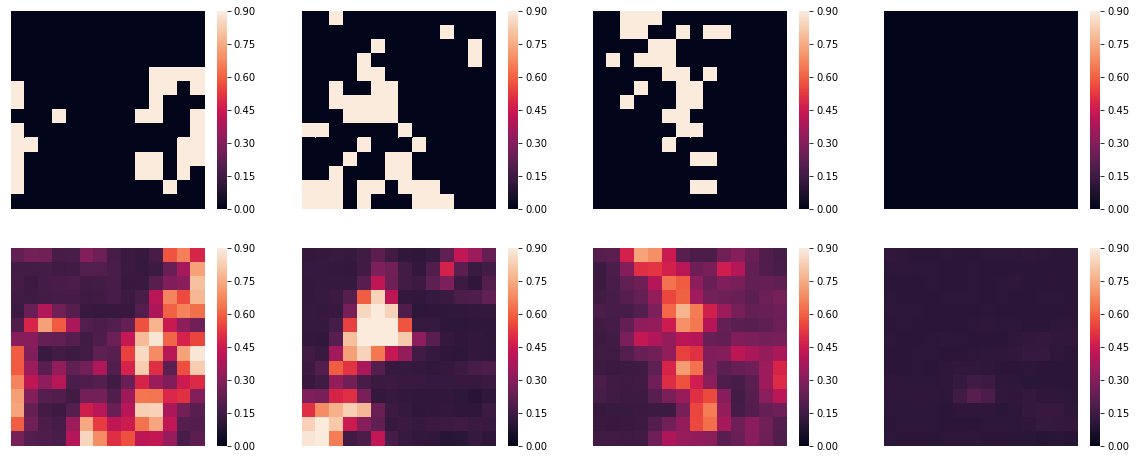

In [270]:
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)
    
""
to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[/ordering[976]//4] 
start = start + 4 # 50, 87, 107 is a concern

2532
2371
297
1243


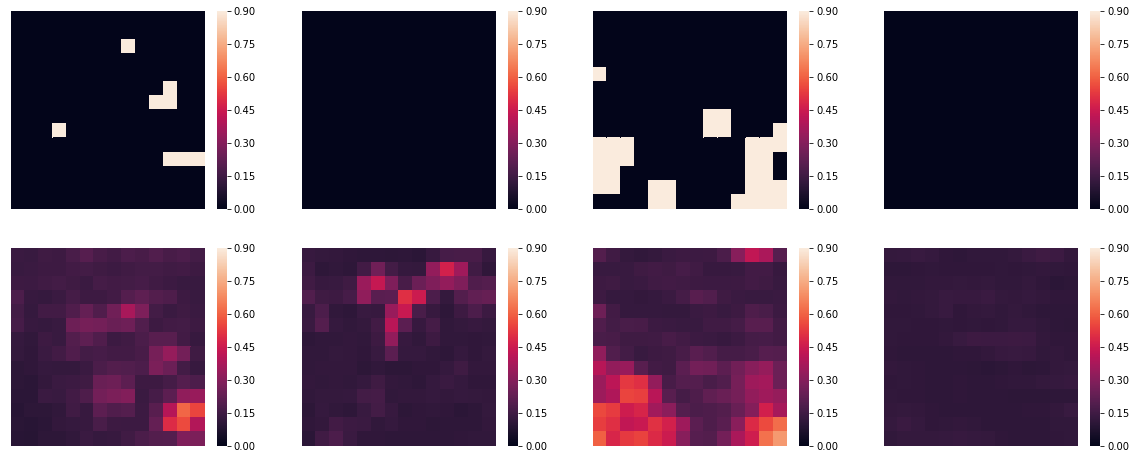

In [303]:
test_losses = []
test_ids = sorted(test_ids)
matrix_ids = random.sample(train_ids, 4)
#matrix_ids = [len(train_x)-28]

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)

In [300]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x // 4 for x in outliers]))]
#plot_ids2[ordering[460]//4] 

In [279]:
calculate_metrics()

Val loss: 0.3409999907016754 Thresh: 0.5 F1: 0.74 Recall: 0.713 Precision: 0.769 Error: 0.078


0.7398178201235472

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.